<a href="https://colab.research.google.com/github/PrernaKumari147/NeuralNetwork/blob/main/Mini_Project_700749909_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Setup and Imports
!pip install --upgrade youtube-dl # Upgrade youtube-dl
!pip install torch torchvision matplotlib opencv-python
!pip install --upgrade yt-dlp
!pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

import yt_dlp as youtube_dl
import torch.nn.functional as F
from torchvision import models

In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Download and Extract Video Frames
def download_video(url, output_path="video.mp4"):
    ydl_opts = {'outtmpl': output_path, 'format': 'mp4'}
    # Use yt-dlp's YoutubeDL class
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

def extract_frames(video_path, output_folder="frames", frame_rate=1):
    os.makedirs(output_folder, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    count = 0
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000 / frame_rate))
        success, image = vidcap.read()
        if success:
            cv2.imwrite(f"{output_folder}/frame{count}.jpg", image)
            count += 1

video_url = "https://www.youtube.com/watch?v=ldaRxgb-dao"  # Replace with your video URL
download_video(video_url)
extract_frames("video.mp4")

[youtube] Extracting URL: https://www.youtube.com/watch?v=ldaRxgb-dao
[youtube] ldaRxgb-dao: Downloading webpage
[youtube] ldaRxgb-dao: Downloading ios player API JSON
[youtube] ldaRxgb-dao: Downloading mweb player API JSON
[youtube] ldaRxgb-dao: Downloading player dad5a960
[youtube] ldaRxgb-dao: Downloading m3u8 information
[info] ldaRxgb-dao: Downloading 1 format(s): 18
[download] Destination: video.mp4
[download] 100% of    2.40MiB in 00:00:01 at 2.21MiB/s   


In [4]:

# Step 3: Dataset and DataLoader
class SiameseDataset(Dataset):
    def __init__(self, frame_folder, transform=None):
        self.frames = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder)])
        self.transform = transform

    def __len__(self):
        return len(self.frames) - 1  # Pairs of consecutive frames

    def __getitem__(self, idx):
        frame1 = Image.open(self.frames[idx])
        frame2 = Image.open(self.frames[idx + 1])
        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
        return frame1, frame2, torch.tensor([1.0])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = SiameseDataset("frames", transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:

# Step 4: Define Masking Function
def mask_image(img, mask_ratio=0.1):
    img = img.clone()
    num_pixels = int(img.size(1) * img.size(2) * mask_ratio)
    mask_indices = torch.randperm(img.size(1) * img.size(2))[:num_pixels]
    img.view(-1)[mask_indices] = 0
    return img

In [6]:
# Increased mask ratio and embedding dimension, plus loss weighting
mask_ratio = 0.2  # Increase mask ratio to challenge the model more
embedding_dim = 512  # Increase embedding dimension for better feature representation

# Define Perceptual Loss (VGG-based)
vgg = models.vgg19(pretrained=True).features.to(device).eval()

def perceptual_loss(x, y):
    # Extract features from the VGG network
    x_features = vgg(x)
    y_features = vgg(y)
    # Calculate the loss (L2 loss of the features)
    return F.mse_loss(x_features, y_features)

# Step 5: Define Siamese Masked Autoencoder Model
class SiameseMaskedAutoencoder(nn.Module):
    def __init__(self, embedding_dim=512):
        super(SiameseMaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        z1, z2 = self.encoder(img1), self.encoder(img2)
        recon1, recon2 = self.decoder(z1), self.decoder(z2)
        return z1, z2, recon1, recon2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 112MB/s]


In [7]:
model = SiameseMaskedAutoencoder().to(device)

# Step 6: Define Loss Functions
criterion_contrastive = nn.MSELoss()
criterion_reconstruction = nn.MSELoss()

In [8]:

# Step 6: Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower learning rate for better convergence
num_epochs = 40  # Increase number of epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for frame1, frame2, labels in data_loader:
        frame1, frame2, labels = frame1.to(device), frame2.to(device), labels.to(device)

        masked_frame1 = mask_image(frame1, mask_ratio)
        masked_frame2 = mask_image(frame2, mask_ratio)

        z1, z2, recon1, recon2 = model(masked_frame1, masked_frame2)

        loss_contrastive = criterion_contrastive(z1, z2)
        loss_reconstruction = 2.0 * (criterion_reconstruction(recon1, frame1) + criterion_reconstruction(recon2, frame2))
        loss = loss_contrastive + loss_reconstruction

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(data_loader):.4f}")

Epoch [1/40], Loss: 0.5739
Epoch [2/40], Loss: 0.2258
Epoch [3/40], Loss: 0.0840
Epoch [4/40], Loss: 0.0555
Epoch [5/40], Loss: 0.0400
Epoch [6/40], Loss: 0.0302
Epoch [7/40], Loss: 0.0245
Epoch [8/40], Loss: 0.0207
Epoch [9/40], Loss: 0.0184
Epoch [10/40], Loss: 0.0168
Epoch [11/40], Loss: 0.0156
Epoch [12/40], Loss: 0.0149
Epoch [13/40], Loss: 0.0141
Epoch [14/40], Loss: 0.0137
Epoch [15/40], Loss: 0.0133
Epoch [16/40], Loss: 0.0130
Epoch [17/40], Loss: 0.0126
Epoch [18/40], Loss: 0.0123
Epoch [19/40], Loss: 0.0123
Epoch [20/40], Loss: 0.0120
Epoch [21/40], Loss: 0.0117
Epoch [22/40], Loss: 0.0116
Epoch [23/40], Loss: 0.0115
Epoch [24/40], Loss: 0.0114
Epoch [25/40], Loss: 0.0112
Epoch [26/40], Loss: 0.0113
Epoch [27/40], Loss: 0.0110
Epoch [28/40], Loss: 0.0110
Epoch [29/40], Loss: 0.0111
Epoch [30/40], Loss: 0.0110
Epoch [31/40], Loss: 0.0108
Epoch [32/40], Loss: 0.0107
Epoch [33/40], Loss: 0.0106
Epoch [34/40], Loss: 0.0106
Epoch [35/40], Loss: 0.0105
Epoch [36/40], Loss: 0.0105
E

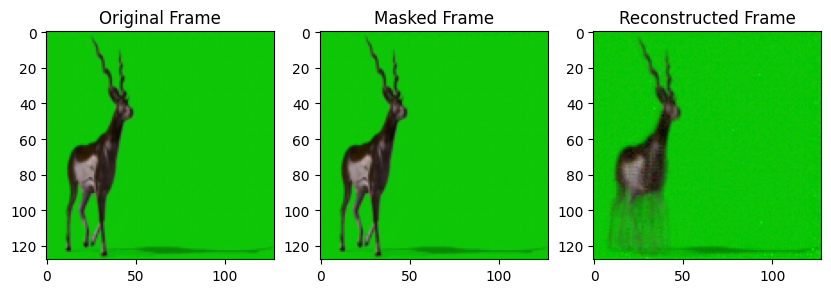

In [9]:

#Step 7: Visualize the reconstructed images
model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(frame1[0].detach().cpu().numpy().transpose(1, 2, 0))  # Original frame
plt.title("Original Frame")
plt.subplot(1, 3, 2)
plt.imshow(masked_frame1[0].detach().cpu().numpy().transpose(1, 2, 0))  # Masked frame
plt.title("Masked Frame")
plt.subplot(1, 3, 3)
plt.imshow(recon1[0].detach().cpu().numpy().transpose(1, 2, 0))  # Reconstructed frame
plt.title("Reconstructed Frame")
plt.show()